# Medical Term Retrieval Analysis

This notebook breaks down the search terms retrieval analysis into logical components that can be run independently.

In [65]:
from collections import OrderedDict
import typing as typ

import pydantic

from agents.analyse_agent import create_analyse_agent
from dataloader.base import DatasetConfig

import hashlib
from pathlib import Path
import config as cnf
import utils as exp_utils

from dataloader import load_dataset, DATASET_CONFIGS

from retrieval.qdrant_search import client as qdrant_client
from retrieval.qdrant_search import models as qdrant_models
from retrieval.qdrant_search import factory as qdrant_factory

## Configuration

Define the configuration parameters for the experiment

In [66]:
class Arguments(pydantic.BaseModel):
    provider: str = "vllm"  # "azure" | "vllm" | "mistral"
    base_model: dict[str, typ.Any] = {
        "provider": "vllm",
        "deployment": "deepseek-ai/DeepSeek-R1-Distill-Llama-70B",
        "api_base": "http://localhost:6539/v1",
        "endpoint": "completions",
        "use_cache": True,
    }

    analyse_agent: dict[str, typ.Any] = {
        "agent_type": "base",
        "prompt_name": "analyse_agent/base_v1",
    }
    temperature: float = 0.0
    max_tokens: int = 10_000
    seed: int = 1  # e.g., "1:2:3:4:5"
    batch_size: int = 2
    num_workers: int = 4
    embed_config: list[dict[str, str]] = [
        {
            "type": "st",
            "model_name": "pritamdeka/S-PubMedBert-MS-MARCO",
            "query_key": "output",
        }
    ]

    qdrant_config: qdrant_models.FactoryConfig = qdrant_models.FactoryConfig()
    distance: str = "Cosine"
    hnsw: dict[str, int] = {"m": 32, "ef_construct": 256}

    rank: int = 25

    experiment_id: str = "search-terms-per-query"
    experiment_name: str = "S-PubMedBert-MS-MARCO"

    debug: bool = False

    def get_hash(self) -> str:
        """Create unique identifier for the arguments"""
        model_dict = self.model_dump(exclude={"experiment_id", "experiment_name"})
        return hashlib.md5(str(model_dict).encode()).hexdigest()

    def get_experiment_folder(self) -> Path:
        """Get the experiment folder path."""
        return (
            cnf.DUMP_FOLDER
            / f"{self.experiment_id}/{self.experiment_name}/{self.get_hash()}"
        )

# Initialize arguments
args = Arguments()

## Data Loading and Preprocessing

Load and prepare the MDACE dataset and ICD trie

In [67]:
# Create experiment folder
args.get_experiment_folder().mkdir(parents=True, exist_ok=True)

# Save configuration
with open(args.get_experiment_folder() / "config.json", "w") as f:
    f.write(args.model_dump_json(indent=2))

# Initialize Qdrant service
qdrant_service = qdrant_client.QdrantSearchService(
    **args.qdrant_config.model_dump()
)

# Build ICD trie and get codes
xml_trie = exp_utils.build_icd_trie(year=2022)
icd10cm = [code.name for code in xml_trie.get_root_codes("cm")]
eval_trie: dict[str, int] = OrderedDict(
    {code: idx for idx, code in enumerate(sorted(icd10cm), start=1)}
)

Downloaded ICD version 2022 successfully!

 Following files will be parsed: ['2022-official-icd-10-pcs-coding-guidelines-updated-december-1-2021.pdf', 
'fy-2022-icd-10-cm-coding-guidelines-updated-02012022.pdf', 'icd10pcs_tables_2022.xml', 'icd10pcs_index_2022.xml', 
'icd10cm_tabular_2022.xml', 'icd10cm_neoplasm_2022.xml', 'icd10cm_index_2022.xml', 'icd10cm_eindex_2022.xml', 
'icd10cm_drug_2022.xml'] 

Output()

Output()

Output()

Output()

In [68]:
# Load and format MDACE dataset
mdace = load_dataset(DatasetConfig(**DATASET_CONFIGS["mdace-icd10cm"]))
mdace = exp_utils.format_dataset(mdace, xml_trie, debug=args.debug)

# Add evidence field
mdace = mdace.map(
    lambda x: {
        **x,
        "evidence": [
            " ".join(
                x["note"][loc[0] : loc[-1] + 1] for loc in annotation["locations"]
            )
            for annotation in x["evidence_spans"]
        ],
    }
)

## Analysis Agent Setup and Processing

Create and run the analysis agent

In [69]:
# Create and initialize analysis agent
analyse_agent = create_analyse_agent(
    **args.analyse_agent,
    sampling_params={
        "temperature": args.temperature,
        "max_tokens": args.max_tokens,
        "seed": args.seed,
    },
)

task_maker = analyse_agent(
    init_client_fn=exp_utils._init_client_fn(**args.base_model),
    seed=args.seed,
)

# Process dataset with analysis agent
analyse_mdace = mdace.map(
    task_maker,
    num_proc=args.num_workers,
    batched=True,
    batch_size=args.batch_size,
    remove_columns=exp_utils._get_dataset(mdace).column_names,
    desc=f"[Analyse Agent] Generating search queries for seed {args.seed}.",
    load_from_cache_file=False,
)

[Analyse Agent] Generating search queries for seed 1. (num_proc=4):   0%|          | 0/556 [00:00<?, ? example…

2025-05-23 09:38:49.774 | INFO     | throughster.core.decorators:wrapper:75 - [0/10] Could not find <answer> tags in response: dissecans (not mentioned)
- Osgood-Schlatter disease (not mentioned)
- Osteochondrosis (not mentioned)
- Slipped capital femoral epiphysis (not mentioned)
- Legg-Calve-Perthes disease (not mentioned)
- Scheuermann's disease (not mentioned)
- Spondylo. Retrying with increased temperature: 0.1
2025-05-23 09:38:49.807 | INFO     | throughster.core.decorators:wrapper:75 - [0/10] Could not find <answer> tags in response:  procedure, IVF, electrolytes, replete, diet, NPO, midnight, procedure, IVF, electrolytes, replete, diet, NPO, midnight, procedure, IVF, electrolytes, replete, diet, NPO, midnight, procedure, IVF, electrolytes, replete, diet, NPO, midnight, procedure. Retrying with increased temperature: 0.1
2025-05-23 09:38:49.813 | INFO     | throughster.core.decorators:wrapper:75 - [0/10] Could not find <answer> tags in response: dissecans (not mentioned)
- Osgoo

## Term Retrieval and Indexing

Process assignable terms and perform retrieval

In [70]:
queries = analyse_mdace.to_list()
embed_config: list[dict[str, str]] = [
        {
            "type": "st",
            "model_name": "pritamdeka/S-PubMedBert-MS-MARCO",
            "query_key": "evidence",
        }
    ]
# Process assignable terms
terms = [
    term.model_dump() for term in xml_trie.index.values()
]
terms.sort(key=lambda x: x["id"])
print(f"Fetched {len(terms)} assignable terms.")

# Create and ensure index
index_finger_print = qdrant_factory.ensure_qdrant_index(
    data=terms,
    text_key="path",
    model_cfg=embed_config,
    hnsw_cfg=args.hnsw,
    distance=args.distance,
    service=qdrant_service,
    payload_keys=["id", "code"],
)

# Perform search
base_evidence_results = qdrant_factory.search(
    data=analyse_mdace.to_list(),
    model_cfg=embed_config,
    service=qdrant_service,
    index_name=index_finger_print,
    limit=25,
)

base_retrieved_codes = []
cross_reference_terms = []
for idx, res in enumerate(base_evidence_results):
    accumulated_codes = set()
    terms = []
    for point in res.points:
        if not point.payload:
            continue
        term = xml_trie.index[point.payload["id"]]
        if term.see:
            terms.append(term.see)
        if term.see_also:
            terms.append(term.see_also)
        accumulated_codes.update(
            xml_trie.get_term_codes(term.id, subterms=False)
        )
    queries[idx]["evidence"].extend(terms)
    base_retrieved_codes.append(list(accumulated_codes))

Fetched 148660 assignable terms.


Output()

Output()

Output()

In [71]:
embed_config: list[dict[str, str]] = [
        {
            "type": "st",
            "model_name": "pritamdeka/S-PubMedBert-MS-MARCO",
            "query_key": "evidence",
        }
    ]

# Perform search
extended_evidence_results = qdrant_factory.search(
    data=queries,
    model_cfg=embed_config,
    service=qdrant_service,
    index_name=index_finger_print,
    limit=25,
)

extended_retrieved_codes = []
for idx, res in enumerate(extended_evidence_results):
    accumulated_codes = set()
    for point in res.points:
        if not point.payload:
            continue
        term = xml_trie.index[point.payload["id"]]
        accumulated_codes.update(
            xml_trie.get_term_codes(term.id, subterms=False)
        )
    extended_retrieved_codes.append(list(accumulated_codes))

Output()

In [54]:
embed_config: list[dict[str, str]] = [
        {
            "type": "st",
            "model_name": "pritamdeka/S-PubMedBert-MS-MARCO",
            "query_key": "output",
        }
    ]
# Process assignable terms
assignable_terms = [
    term.model_dump() for term in xml_trie.index.values() if term.code
]
assignable_terms.sort(key=lambda x: x["id"])
print(f"Fetched {len(assignable_terms)} assignable terms.")

# Create and ensure index
index_finger_print = qdrant_factory.ensure_qdrant_index(
    data=assignable_terms,
    text_key="path",
    model_cfg=embed_config,
    hnsw_cfg=args.hnsw,
    distance=args.distance,
    service=qdrant_service,
    payload_keys=["id", "code"],
)

# Perform search
assign_agent_results = qdrant_factory.search(
    data=analyse_mdace.to_list(),
    model_cfg=embed_config,
    service=qdrant_service,
    index_name=index_finger_print,
    limit=10,
)
agent_retrieved_codes = []
for res in assign_agent_results:
    accumulated_codes = set()
    terms = []
    for point in res.points:
        if not point.payload:
            continue
        terms.append(point.payload["id"])
        accumulated_codes.update(
            xml_trie.get_term_codes(point.payload["id"], subterms=False)
        )
    agent_retrieved_codes.append(list(accumulated_codes))

Fetched 116687 assignable terms.


Output()

## Evaluation

Plot recall for each chapter

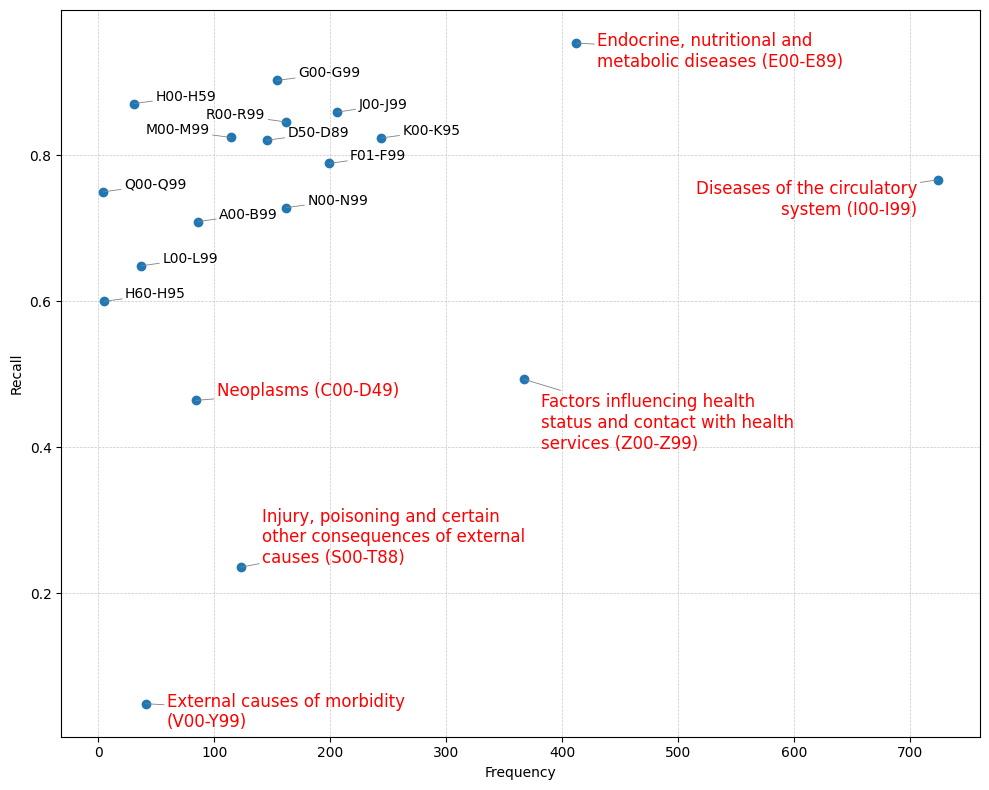

In [191]:
import matplotlib.pyplot as plt
import pandas as pd
import textwrap                       # NEW
from collections import Counter, defaultdict
import numpy as np

# --- build chapter_data exactly as before ---
all_target_codes = [code for row in mdace["targets"] for code in row]
codes_by_chapter = [xml_trie.get_chapter_id(code) for code in all_target_codes]
chapters = {
    xml_trie.get_chapter_id(code): xml_trie.get_chapter(code) for code in all_target_codes
}
chapter_freq = Counter(codes_by_chapter)

chapter_data = defaultdict(dict)
for chapter_id, freq in chapter_freq.items():
    chapter_data[chapter_id] = {
        "frequency": freq,
        "label": f"{chapters[chapter_id].min}-{chapters[chapter_id].max}",
    }

# --- per-chapter recall ---
chapters_tp = Counter()
chapters_total = Counter()

for idx, res in enumerate(evidence_retrieved_codes):
    row = mdace[idx]
    target_codes = row["targets"]

    for code in target_codes:
        ch_id = xml_trie.get_chapter_id(code)
        chapters_total[ch_id] += 1
        if code in res:
            chapters_tp[ch_id] += 1

# --- dataframe for plotting ---
total_targets = len(all_target_codes)
rows = []
for ch_id, freq in chapter_freq.items():
    recall = chapters_tp[ch_id] / chapters_total[ch_id] if chapters_total[ch_id] else 0.0
    rows.append(
        {
            "chapter_id": ch_id,
            "frequency": freq,
            "recall": recall,
            "label": chapter_data[ch_id]["label"],
        }
    )

df = pd.DataFrame(rows)
# df = df[df["frequency"] >= 10]

# -----------------------------------------------------------------------------   
# Scatter plot with call-out labels
plt.figure(figsize=(10, 8))
plt.scatter(df["frequency"], df["recall"], zorder=2)
plt.xlabel("Frequency")
plt.ylabel("Recall")

# Pre-compute medians to decide which way to push each label
x_med = df["frequency"].median()
y_med = df["recall"].median()

manual_offsets = {
    "I00-I99":   {"dx": -15, "dy": 0, "ha": "right", "va": "top"},
    "E00-E89":   {"dx": 15, "dy": 8, "ha": "left", "va": "top"},
    "Z00-Z99":   {"dx":  12, "dy": -10, "ha": "left",  "va": "top"},
    "V00-Y99":   {"dx": 15, "dy": 8, "ha": "left", "va": "top"},
    "M00-M99":   {"dx": -15, "dy": 0,  "ha": "right", "va": "bottom"},
    "R00-R99":   {"dx": -15, "dy": 0,  "ha": "right", "va": "bottom"},
    # fallback
    "default":   {"dx": 15, "dy": 0,    "ha": "left",  "va": "bottom"},
}

highlight_labels = ["I00-I99", "Z00-Z99", "E00-E89", "V00-Y99", "C00-D49", "S00-T88"]
for _, r in df.iterrows():
    x, y, label, ch_id = r["frequency"], r["recall"], r["label"], r["chapter_id"]
    color = "red" if label in highlight_labels else "black"
    font_size = 12 if label in highlight_labels else 10
    # Pick a direction: push left or right, up or down away from the plot centre

    opts = manual_offsets.get(r["label"], manual_offsets["default"])
    dx, dy = opts["dx"], opts["dy"]
    ha, va = opts["ha"], opts["va"]
    

    if label in highlight_labels:
        label = chapters[ch_id].description

    # Wrap the text so it does not form one long line
    wrapped = textwrap.fill(label, width=32)

    # Annotate with an arrow-less leader line (arrowstyle "-" draws a straight line)
    plt.annotate(
        wrapped,
        xy=(x, y),
        xytext=(dx, dy),
        textcoords="offset points",
        ha=ha,
        va=va,
        fontsize=font_size,
        color=color,
        arrowprops=dict(
            arrowstyle="-",
            shrinkA=0,
            shrinkB=0,
            lw=0.6,
            color="grey",
        ),
        zorder=3
    )

plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()


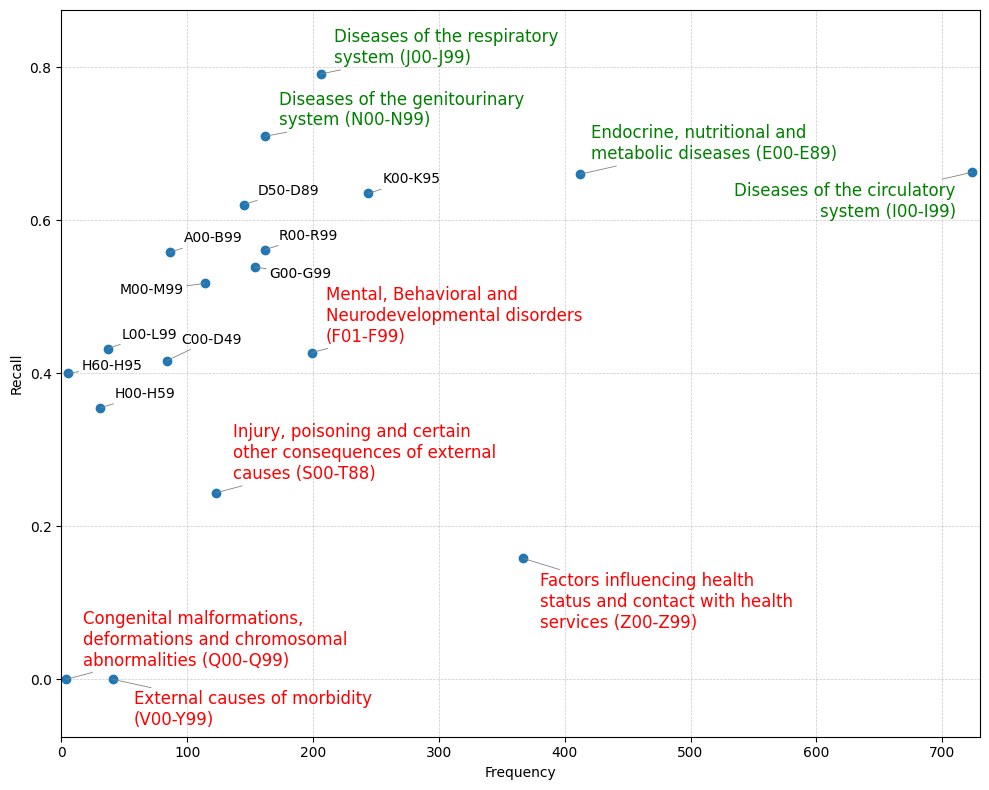

In [245]:
import matplotlib.pyplot as plt
import pandas as pd
import textwrap                       # NEW
from collections import Counter, defaultdict

# --- build chapter_data exactly as before ---
all_target_codes = [code for row in mdace["targets"] for code in row]
codes_by_chapter = [xml_trie.get_chapter_id(code) for code in all_target_codes]
chapters = {
    xml_trie.get_chapter_id(code): xml_trie.get_chapter(code) for code in all_target_codes
}
chapter_freq = Counter(codes_by_chapter)

chapter_data = defaultdict(dict)
for chapter_id, freq in chapter_freq.items():
    chapter_data[chapter_id] = {
        "frequency": freq,
        "label": f"{chapters[chapter_id].min}-{chapters[chapter_id].max}",
    }

# --- per-chapter recall ---
chapters_tp = Counter()
chapters_total = Counter()

for idx, res in enumerate(agent_retrieved_codes):
    row = mdace[idx]
    target_codes = row["targets"]

    for code in target_codes:
        ch_id = xml_trie.get_chapter_id(code)
        chapters_total[ch_id] += 1
        if code in res:
            chapters_tp[ch_id] += 1

# --- dataframe for plotting ---
total_targets = len(all_target_codes)
rows = []
for ch_id, freq in chapter_freq.items():
    recall = chapters_tp[ch_id] / chapters_total[ch_id] if chapters_total[ch_id] else 0.0
    rows.append(
        {
            "chapter_id": ch_id,
            "frequency": freq,
            "recall": recall,
            "label": chapter_data[ch_id]["label"],
        }
    )

df = pd.DataFrame(rows)
# df = df[df["frequency"] >= 10]

# -----------------------------------------------------------------------------   
# Scatter plot with call-out labels
plt.figure(figsize=(10, 8))
plt.scatter(df["frequency"], df["recall"], zorder=2)
plt.xlabel("Frequency")
plt.ylabel("Recall")

# Pre-compute medians to decide which way to push each label
x_med = df["frequency"].median()
y_med = df["recall"].median()

manual_offsets = {
    "I00-I99":   {"dx": -12, "dy": -7, "ha": "right", "va": "top"},
    "Z00-Z99":   {"dx":  12, "dy": -10, "ha": "left",  "va": "top"},
    "E00-E89":   {"dx":   8, "dy": 8,   "ha": "left",  "va": "bottom"},
    "V00-Y99":   {"dx": 15, "dy": -8, "ha": "left", "va": "top"},
    "Q00-Q99":   {"dx": 12, "dy": 7, "ha": "left", "va": "bottom"},  # vertically above
    "C00-D49":   {"dx":  10, "dy": 10,  "ha": "left",  "va": "bottom"},
    "S00-T88":   {"dx": 12, "dy": 7, "ha": "left", "va": "bottom"},     # directly below
    "M00-M99":   {"dx": -15, "dy": -10,  "ha": "right", "va": "bottom"},
    "H60-H95": {"dx": 10, "dy": 10,  "ha": "left", "va": "top"},
    "G00-G99": {"dx": 10, "dy": -10,  "ha": "left", "va": "bottom"},
    # fallback
    "default":   {"dx": 10, "dy": 5,    "ha": "left",  "va": "bottom"},
}


red_highlight_labels = ["Q00-Q99", "V00-Y99", "V00-Y99", "Z00-Z99", "S00-T88", "F01-F99"]
green_highlight_labels = ["I00-I99", "J00-J99", "N00-N99", "E00-E89"]
highlight_labels = red_highlight_labels + green_highlight_labels
for _, r in df.iterrows():
    x, y, label, ch_id = r["frequency"], r["recall"], r["label"], r["chapter_id"]
    color = "red" if label in red_highlight_labels else ("green" if label in green_highlight_labels else "black")
    font_size = 12 if label in highlight_labels  else 10
    # Pick a direction: push left or right, up or down away from the plot centre

    opts = manual_offsets.get(r["label"], manual_offsets["default"])
    dx, dy = opts["dx"], opts["dy"]
    ha, va = opts["ha"], opts["va"]

    if label in highlight_labels:
        label = chapters[ch_id].description
    wrapped = textwrap.fill(label, width=32)

    # Annotate with an arrow-less leader line (arrowstyle "-" draws a straight line)
    plt.annotate(
        wrapped,
        xy=(x, y),
        xytext=(dx, dy),
        textcoords="offset points",
        ha=ha,
        va=va,
        fontsize=font_size,
        color=color,
        arrowprops=dict(
            arrowstyle="-",
            shrinkA=0,
            shrinkB=0,
            lw=0.6,
            color="grey",
        ),
        zorder=3
    )
plt.ylim(-0.075, 0.875)
plt.xlim(0, 730)
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

## Word cloud


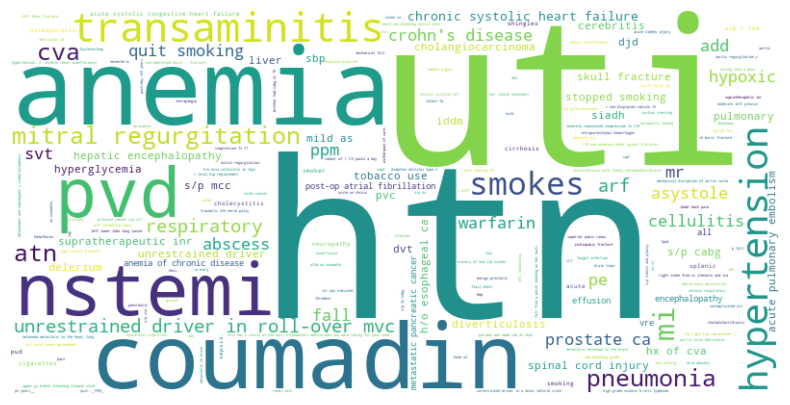

In [209]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

false_negative_spans = []

for idx, res in enumerate(evidence_retrieved_codes):
    row = mdace[idx]
    target_codes = row["targets"]
    target2span = {annotation["code"]: [row["note"][loc[0] : loc[-1] + 1]] for annotation in row["evidence_spans"] for loc in annotation["locations"]}

    for code in target_codes:
        if code in res:
            continue
        false_negative_spans.extend(
            target2span[code]
        )

cleaned_spans = [span.replace('\n', ' ').lower() for span in false_negative_spans]
phrase_freqs = Counter(cleaned_spans)

# Step 2: Generate word cloud with collocations disabled
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    collocations=False  # Ensures no automatic phrase detection/splitting
).generate_from_frequencies(phrase_freqs)

# Step 3: Plot
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [206]:
phrase_freqs

Counter({'htn': 15,
         'uti': 15,
         'anemia': 14,
         'coumadin': 10,
         'nstemi': 10,
         'pvd': 9,
         'transaminitis': 8,
         'hypertension': 7,
         'smokes': 5,
         'mi': 4,
         'mitral regurgitation': 4,
         'pneumonia': 4,
         'atn': 4,
         'cva': 4,
         'unrestrained driver in roll-over mvc': 4,
         'arf': 4,
         'respiratory': 4,
         'svt': 3,
         'abscess': 3,
         'add': 3,
         'ppm': 3,
         'prostate ca': 3,
         'asystole': 3,
         'fall': 3,
         'quit smoking': 3,
         'cellulitis': 3,
         'pe': 3,
         'hypoxic': 3,
         'warfarin': 3,
         'mr': 3,
         "crohn's disease": 3,
         'chronic systolic heart failure': 3,
         'diverticulosis': 2,
         'hx of cva': 2,
         'spinal cord injury': 2,
         's/p mcc': 2,
         'unrestrained driver': 2,
         'dvt': 2,
         'stopped smoking': 2,
         'h/o 

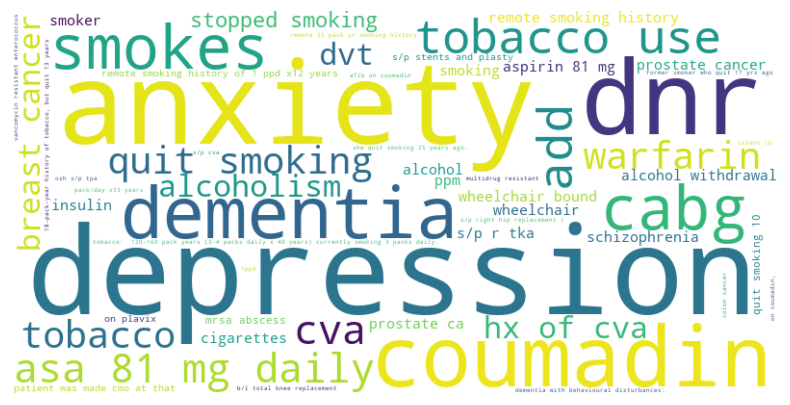

In [216]:
chapters = {"cm_5", "cm_21"}
chapter_false_negatives = []
for idx, res in enumerate(agent_retrieved_codes):
    row = mdace[idx]
    target_codes = row["targets"]
    target2span = target2span = {annotation["code"]: [row["note"][loc[0] : loc[-1] + 1]] for annotation in row["evidence_spans"] for loc in annotation["locations"]}

    for code in target_codes:
        ch_id = xml_trie.get_chapter_id(code)
        if ch_id not in chapters:
            continue
        if code in res:
            continue
        chapter_false_negatives.extend(
            target2span[code]
        )

cleaned_spans = [span.replace('\n', ' ').lower() for span in chapter_false_negatives]
phrase_freqs = Counter(cleaned_spans)

# Step 2: Generate word cloud with collocations disabled
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    collocations=False  # Ensures no automatic phrase detection/splitting
).generate_from_frequencies(phrase_freqs)

# Step 3: Plot
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [215]:
target2span

{'I13.0': ['Hypertension'],
 'I50.32': ['Chronic diastolic heart failure'],
 'Z95.0': ['s/p pacemaker ['],
 'E03.9': ['Hypothyroidism'],
 'C90.00': ['Multiple myeloma'],
 'N18.9': ['Chronic renal insufficiency'],
 'K21.9': ['Gastroesophageal reflux disease'],
 'Z96.651': ['Right total knee replacement'],
 'I27.20': ['Pulmonary hypertension'],
 'I48.91': ['post-op\natrial fibrillation']}

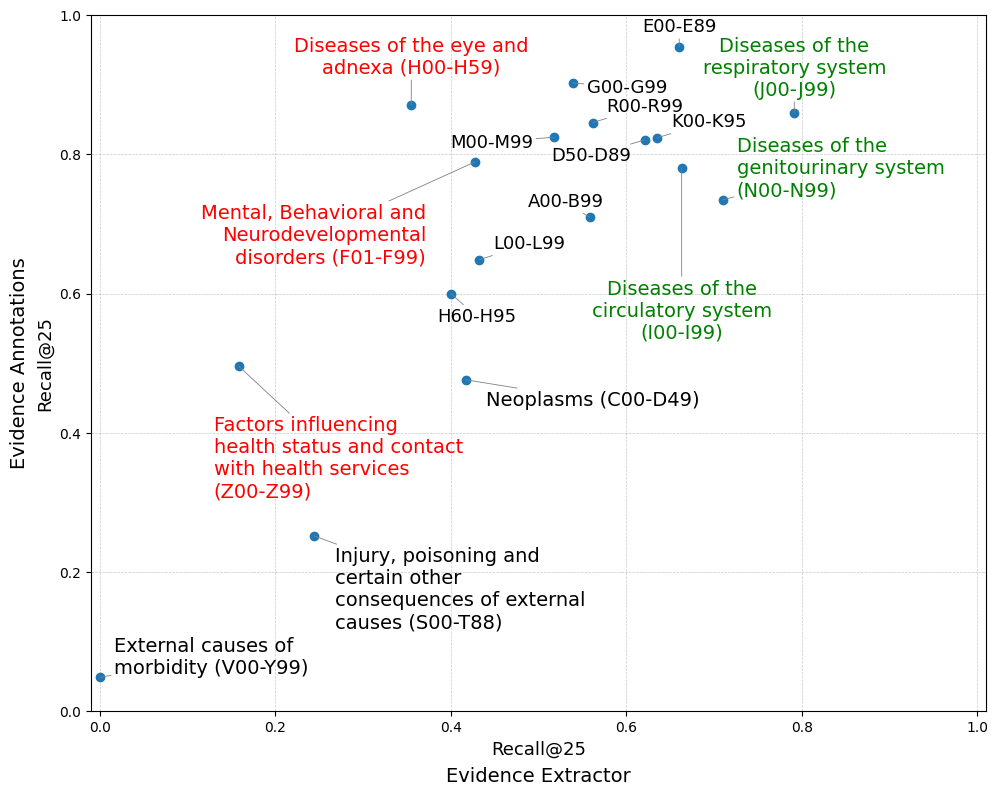

In [55]:
all_target_codes = [code for row in mdace["targets"] for code in row]
codes_by_chapter = [xml_trie.get_chapter_id(code) for code in all_target_codes]
chapters = {
    xml_trie.get_chapter_id(code): xml_trie.get_chapter(code) for code in all_target_codes
}
chapter_freq = Counter(codes_by_chapter)

chapter_data = defaultdict(dict)
for chapter_id, freq in chapter_freq.items():
    chapter_data[chapter_id] = {
        "label": f"{chapters[chapter_id].min}-{chapters[chapter_id].max}",
    }

# --- per-chapter recall ---
agent_chapters_tp = Counter()
agent_chapters_total = Counter()

for idx, res in enumerate(agent_retrieved_codes):
    row = mdace[idx]
    target_codes = row["targets"]

    for code in target_codes:
        ch_id = xml_trie.get_chapter_id(code)
        agent_chapters_total[ch_id] += 1
        if code in res:
            agent_chapters_tp[ch_id] += 1

evidence_chapters_tp = Counter()
evidence_chapters_total = Counter()

for idx, res in enumerate(evidence_retrieved_codes):
    row = mdace[idx]
    target_codes = row["targets"]

    for code in target_codes:
        ch_id = xml_trie.get_chapter_id(code)
        evidence_chapters_total[ch_id] += 1
        if code in res:
            evidence_chapters_tp[ch_id] += 1

# --- dataframe for plotting ---
total_targets = len(all_target_codes)
rows = []
for ch_id, freq in chapter_freq.items():
    agent_recall = agent_chapters_tp[ch_id] / agent_chapters_total[ch_id] if agent_chapters_total[ch_id] else 0.0
    evidence_recall = evidence_chapters_tp[ch_id] / evidence_chapters_total[ch_id] if evidence_chapters_total[ch_id] else 0.0
    rows.append(
        {
            "chapter_id": ch_id,
            "frequency": freq,
            "evidence_recall": evidence_recall,
            "agent_recall": agent_recall,
            "label": chapter_data[ch_id]["label"],
        }
    )

df = pd.DataFrame(rows)
df = df[df["frequency"] >= 5]

# -----------------------------------------------------------------------------   
# Scatter plot with call-out labels
plt.figure(figsize=(10, 8))
plt.scatter(df["agent_recall"], df["evidence_recall"], zorder=2)
plt.xlabel("Recall@25", fontsize=13)
plt.ylabel("Recall@25", fontsize=13)

plt.text(
    0.5, -0.08, "Evidence Extractor",
    transform=plt.gca().transAxes,
    ha="center", va="top", fontsize=14
)

# Add subtitle beside y-axis
plt.text(
    -0.08, 0.5, "Evidence Annotations",
    transform=plt.gca().transAxes,
    ha="center", va="center", rotation="vertical", fontsize=14
)

# Pre-compute medians to decide which way to push each label
x_med = df["agent_recall"].median()
y_med = df["evidence_recall"].median()

manual_offsets = {
    "I00-I99":   {"dx": 0, "dy": -80, "ha": "center", "va": "top"},
    "Z00-Z99": {"dx": -18, "dy": -36,  "ha": "left", "va": "top"},
    "J00-J99": {"dx": 0, "dy": 10, "ha": "center", "va": "bottom"},
    "E00-E89": {"dx": 0, "dy": 8, "ha": "center", "va": "bottom"},
    "Q00-Q99":   {"dx": 12, "dy": 7, "ha": "left", "va": "bottom"},  # vertically above
    "C00-D49":   {"dx": 15, "dy": -8, "ha": "left", "va": "top"},
    "S00-T88":   {"dx": 15, "dy": -8, "ha": "left", "va": "top"},     # directly below
    "M00-M99":   {"dx": -15, "dy": -10,  "ha": "right", "va": "bottom"},
    "H60-H95": {"dx": -10, "dy": -10,  "ha": "left", "va": "top"},
    "H00-H59": {"dx": 0, "dy": 20, "ha": "center", "va": "bottom"},
    "G00-G99": {"dx": 10, "dy": -10,  "ha": "left", "va": "bottom"},
    "F01-F99": {"dx": -35, "dy": -30, "ha": "right", "va": "top"},
    "A00-B99": {"dx": 10, "dy": 5,    "ha": "right",  "va": "bottom"},
    "D50-D89": {"dx": -10, "dy": -5, "ha": "right", "va": "top"},
    "N00-N99":   {"dx":  10, "dy": 0,  "ha": "left",  "va": "bottom"},
    "V00-Y99":   {"dx":  10, "dy": 0,  "ha": "left",  "va": "bottom"},
    "default":   {"dx": 10, "dy": 5,    "ha": "left",  "va": "bottom"},
}


red_highlight_labels = ["Q00-Q99", "H00-H59", "Z00-Z99", "F01-F99"]
green_highlight_labels = ["J00-J99", "N00-N99", "I00-I99"]
highlight_labels = red_highlight_labels + green_highlight_labels
for _, r in df.iterrows():
    x, y, label, ch_id = r["agent_recall"], r["evidence_recall"], r["label"], r["chapter_id"]
    color = "red" if label in red_highlight_labels else ("green" if label in green_highlight_labels else "black")
    font_size = 13
    # Pick a direction: push left or right, up or down away from the plot centre

    opts = manual_offsets.get(r["label"], manual_offsets["default"])
    dx, dy = opts["dx"], opts["dy"]
    ha, va = opts["ha"], opts["va"]

    if label in highlight_labels or label in["V00-Y99", "C00-D49", "S00-T88"]:
        label = chapters[ch_id].description
        font_size = 14
    wrapped = textwrap.fill(label, width=25)

    # Annotate with an arrow-less leader line (arrowstyle "-" draws a straight line)
    plt.annotate(
        wrapped,
        xy=(x, y),
        xytext=(dx, dy),
        textcoords="offset points",
        ha=ha,
        va=va,
        fontsize=font_size,
        color=color,
        arrowprops=dict(
            arrowstyle="-",
            shrinkA=0,
            shrinkB=0,
            lw=0.6,
            color="grey",
        ),
        zorder=3
    )
plt.ylim(0.0, 1.0)
plt.xlim(-0.01, 1.01)
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

In [322]:
chapters

{'cm_4': cm_4 E00-E89 Endocrine, nutritional and metabolic diseases (E00-E89),
 'cm_9': cm_9 I00-I99 Diseases of the circulatory system (I00-I99),
 'cm_21': cm_21 Z00-Z99 Factors influencing health status and contact with health services (Z00-Z99),
 'cm_5': cm_5 F01-F99 Mental, Behavioral and Neurodevelopmental disorders (F01-F99),
 'cm_11': cm_11 K00-K95 Diseases of the digestive system (K00-K95),
 'cm_1': cm_1 A00-B99 Certain infectious and parasitic diseases (A00-B99),
 'cm_6': cm_6 G00-G99 Diseases of the nervous system (G00-G99),
 'cm_13': cm_13 M00-M99 Diseases of the musculoskeletal system and connective tissue (M00-M99),
 'cm_10': cm_10 J00-J99 Diseases of the respiratory system (J00-J99),
 'cm_18': cm_18 R00-R99 Symptoms, signs and abnormal clinical and laboratory findings, not elsewhere classified (R00-R99),
 'cm_14': cm_14 N00-N99 Diseases of the genitourinary system (N00-N99),
 'cm_3': cm_3 D50-D89 Diseases of the blood and blood-forming organs and certain disorders involvi

In [321]:
chapter_freq

Counter({'cm_9': 724,
         'cm_4': 412,
         'cm_21': 367,
         'cm_11': 244,
         'cm_10': 206,
         'cm_5': 199,
         'cm_18': 162,
         'cm_14': 162,
         'cm_6': 154,
         'cm_3': 145,
         'cm_19': 123,
         'cm_13': 114,
         'cm_1': 86,
         'cm_2': 84,
         'cm_20': 41,
         'cm_12': 37,
         'cm_7': 31,
         'cm_8': 5,
         'cm_17': 4})

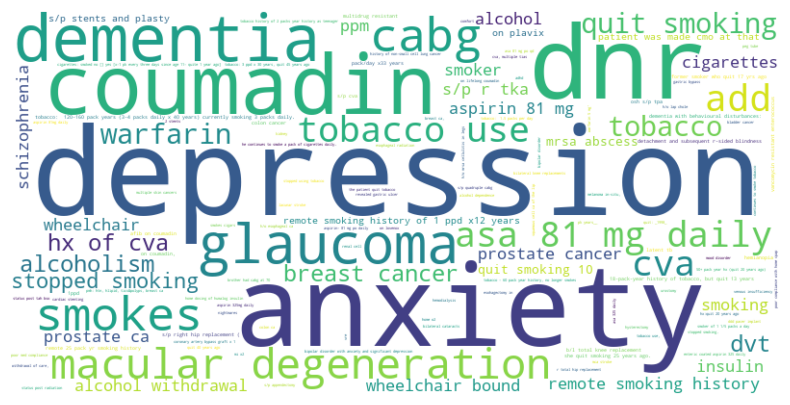

In [319]:
chapters = {"cm_5", "cm_21", "cm_7"}
chapter_false_negatives = []
for idx, res in enumerate(agent_retrieved_codes):
    row = mdace[idx]
    target_codes = row["targets"]
    target2span = target2span = {annotation["code"]: [row["note"][loc[0] : loc[-1] + 1]] for annotation in row["evidence_spans"] for loc in annotation["locations"]}

    for code in target_codes:
        ch_id = xml_trie.get_chapter_id(code)
        if ch_id not in chapters:
            continue
        if code in res:
            continue
        chapter_false_negatives.extend(
            target2span[code]
        )

cleaned_spans = [span.replace('\n', ' ').lower() for span in chapter_false_negatives]
phrase_freqs = Counter(cleaned_spans)

# Step 2: Generate word cloud with collocations disabled
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    collocations=False  # Ensures no automatic phrase detection/splitting
).generate_from_frequencies(phrase_freqs)

# Step 3: Plot
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

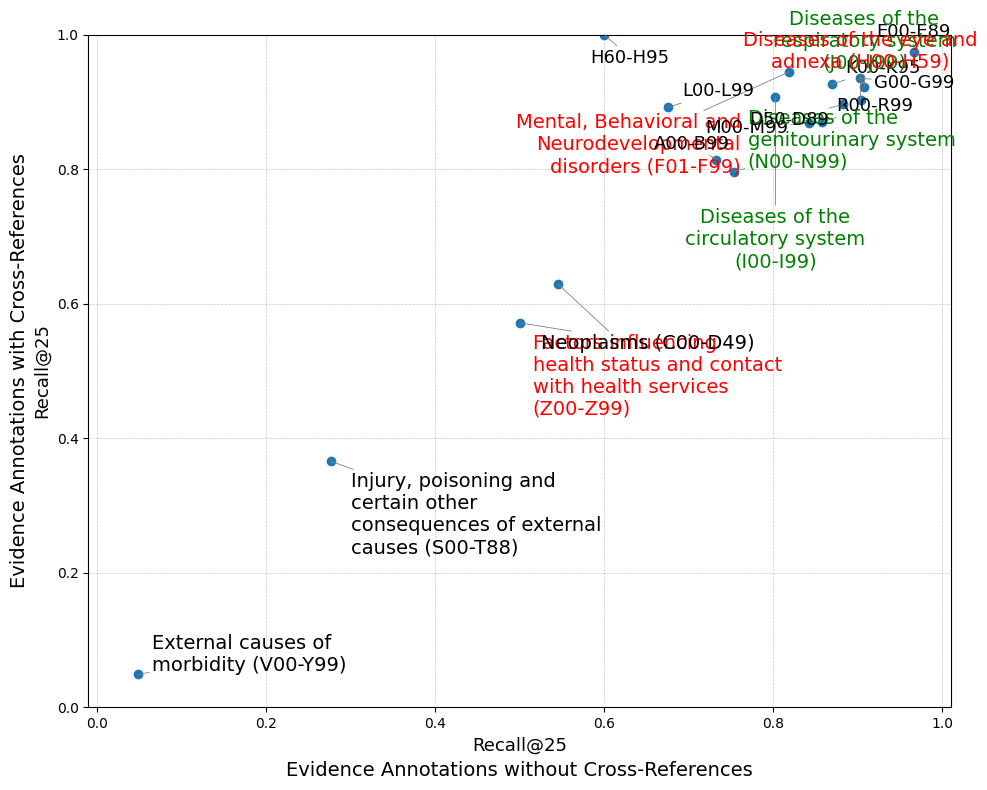

In [72]:
import matplotlib.pyplot as plt
import pandas as pd
import textwrap                       # NEW
from collections import Counter, defaultdict

all_target_codes = [code for row in mdace["targets"] for code in row]
codes_by_chapter = [xml_trie.get_chapter_id(code) for code in all_target_codes]
chapters = {
    xml_trie.get_chapter_id(code): xml_trie.get_chapter(code) for code in all_target_codes
}
chapter_freq = Counter(codes_by_chapter)

chapter_data = defaultdict(dict)
for chapter_id, freq in chapter_freq.items():
    chapter_data[chapter_id] = {
        "label": f"{chapters[chapter_id].min}-{chapters[chapter_id].max}",
    }

# --- per-chapter recall ---
base_chapters_tp = Counter()
base_chapters_total = Counter()

for idx, res in enumerate(base_retrieved_codes):
    row = mdace[idx]
    target_codes = row["targets"]

    for code in target_codes:
        ch_id = xml_trie.get_chapter_id(code)
        base_chapters_total[ch_id] += 1
        if code in res:
            base_chapters_tp[ch_id] += 1

extended_chapters_tp = Counter()
extended_chapters_total = Counter()

for idx, res in enumerate(extended_retrieved_codes):
    row = mdace[idx]
    target_codes = row["targets"]

    for code in target_codes:
        ch_id = xml_trie.get_chapter_id(code)
        extended_chapters_total[ch_id] += 1
        if code in res:
            extended_chapters_tp[ch_id] += 1

# --- dataframe for plotting ---
total_targets = len(all_target_codes)
rows = []
for ch_id, freq in chapter_freq.items():
    base_recall = base_chapters_tp[ch_id] / base_chapters_total[ch_id] if base_chapters_total[ch_id] else 0.0
    extended_recall = extended_chapters_tp[ch_id] / extended_chapters_total[ch_id] if extended_chapters_total[ch_id] else 0.0
    rows.append(
        {
            "chapter_id": ch_id,
            "frequency": freq,
            "extended_recall": extended_recall,
            "base_recall": base_recall,
            "label": chapter_data[ch_id]["label"],
        }
    )

df = pd.DataFrame(rows)
df = df[df["frequency"] >= 5]

# -----------------------------------------------------------------------------   
# Scatter plot with call-out labels
plt.figure(figsize=(10, 8))
plt.scatter(df["base_recall"], df["extended_recall"], zorder=2)
plt.xlabel("Recall@25", fontsize=13)
plt.ylabel("Recall@25", fontsize=13)

plt.text(
    0.5, -0.08, "Evidence Annotations without Cross-References",
    transform=plt.gca().transAxes,
    ha="center", va="top", fontsize=14
)

# Add subtitle beside y-axis
plt.text(
    -0.08, 0.5, "Evidence Annotations with Cross-References",
    transform=plt.gca().transAxes,
    ha="center", va="center", rotation="vertical", fontsize=14
)

# Pre-compute medians to decide which way to push each label
x_med = df["base_recall"].median()
y_med = df["extended_recall"].median()

manual_offsets = {
    "I00-I99":   {"dx": 0, "dy": -80, "ha": "center", "va": "top"},
    "Z00-Z99": {"dx": -18, "dy": -36,  "ha": "left", "va": "top"},
    "J00-J99": {"dx": 0, "dy": 10, "ha": "center", "va": "bottom"},
    "E00-E89": {"dx": 0, "dy": 8, "ha": "center", "va": "bottom"},
    "Q00-Q99":   {"dx": 12, "dy": 7, "ha": "left", "va": "bottom"},  # vertically above
    "C00-D49":   {"dx": 15, "dy": -8, "ha": "left", "va": "top"},
    "S00-T88":   {"dx": 15, "dy": -8, "ha": "left", "va": "top"},     # directly below
    "M00-M99":   {"dx": -15, "dy": -10,  "ha": "right", "va": "bottom"},
    "H60-H95": {"dx": -10, "dy": -10,  "ha": "left", "va": "top"},
    "H00-H59": {"dx": 0, "dy": 20, "ha": "center", "va": "bottom"},
    "G00-G99": {"dx": 10, "dy": -10,  "ha": "left", "va": "bottom"},
    "F01-F99": {"dx": -35, "dy": -30, "ha": "right", "va": "top"},
    "A00-B99": {"dx": 10, "dy": 5,    "ha": "right",  "va": "bottom"},
    "D50-D89": {"dx": -10, "dy": -5, "ha": "right", "va": "top"},
    "N00-N99":   {"dx":  10, "dy": 0,  "ha": "left",  "va": "bottom"},
    "V00-Y99":   {"dx":  10, "dy": 0,  "ha": "left",  "va": "bottom"},
    "default":   {"dx": 10, "dy": 5,    "ha": "left",  "va": "bottom"},
}


red_highlight_labels = ["Q00-Q99", "H00-H59", "Z00-Z99", "F01-F99"]
green_highlight_labels = ["J00-J99", "N00-N99", "I00-I99"]
highlight_labels = red_highlight_labels + green_highlight_labels
for _, r in df.iterrows():
    x, y, label, ch_id = r["base_recall"], r["extended_recall"], r["label"], r["chapter_id"]
    color = "red" if label in red_highlight_labels else ("green" if label in green_highlight_labels else "black")
    font_size = 13
    # Pick a direction: push left or right, up or down away from the plot centre

    opts = manual_offsets.get(r["label"], manual_offsets["default"])
    dx, dy = opts["dx"], opts["dy"]
    ha, va = opts["ha"], opts["va"]

    if label in highlight_labels or label in["V00-Y99", "C00-D49", "S00-T88"]:
        label = chapters[ch_id].description
        font_size = 14
    wrapped = textwrap.fill(label, width=25)

    # Annotate with an arrow-less leader line (arrowstyle "-" draws a straight line)
    plt.annotate(
        wrapped,
        xy=(x, y),
        xytext=(dx, dy),
        textcoords="offset points",
        ha=ha,
        va=va,
        fontsize=font_size,
        color=color,
        arrowprops=dict(
            arrowstyle="-",
            shrinkA=0,
            shrinkB=0,
            lw=0.6,
            color="grey",
        ),
        zorder=3
    )
plt.ylim(0.0, 1.0)
plt.xlim(-0.01, 1.01)
plt.grid(True, linestyle="--", linewidth=0.5, alpha=0.7)
plt.tight_layout()
plt.show()

In [47]:
df

,chapter_id,frequency,extended_recall,base_recall,label
0,cm_4,412,0.953883,0.953883,E00-E89
1,cm_9,724,0.780387,0.766575,I00-I99
2,cm_21,367,0.495913,0.493188,Z00-Z99
3,cm_5,199,0.788945,0.788945,F01-F99
4,cm_11,244,0.823770,0.823770,K00-K95
5,cm_1,86,0.709302,0.709302,A00-B99
6,cm_6,154,0.902597,0.902597,G00-G99
7,cm_13,114,0.824561,0.824561,M00-M99
8,cm_10,206,0.859223,0.859223,J00-J99
9,cm_18,162,0.845679,0.845679,R00-R99


In [63]:
# Compute recall difference
df["recall_change"] = df["extended_recall"] - df["base_recall"]

# Compute overall weighted values
total_freq = df["frequency"].sum()
overall_extended = (df["frequency"] * df["extended_recall"]).sum() / total_freq
overall_base = (df["frequency"] * df["base_recall"]).sum() / total_freq
overall_change = overall_extended - overall_base

# Create summary row
summary_row = pd.DataFrame([{
    "chapter_id": "overall",
    "frequency": total_freq,
    "extended_recall": overall_extended,
    "base_recall": overall_base,
    "recall_change": overall_change,
    "label": "All Chapters"
}])

# Combine
df_with_summary = pd.concat([df, summary_row], ignore_index=True)

In [64]:
df.rename(columns={
    "base_recall": "base",
    "extended_recall": "with_cross_references"
}, inplace=True)

# Compute recall difference
df["recall_change"] = df["with_cross_references"] - df["base"]

# Compute overall weighted values
total_freq = df["frequency"].sum()
overall_base = (df["frequency"] * df["base"]).sum() / total_freq
overall_cross = (df["frequency"] * df["with_cross_references"]).sum() / total_freq
overall_change = overall_cross - overall_base

# Create summary row
summary_row = pd.DataFrame([{
    "chapter_id": "overall",
    "frequency": total_freq,
    "base": overall_base,
    "with_cross_references": overall_cross,
    "recall_change": overall_change,
    "label": "All Chapters"
}])


df_with_summary = pd.concat([df, summary_row], ignore_index=True)
df_with_summary = df_with_summary[["chapter_id", "frequency", "base", "with_cross_references", "recall_change", "label"]]

df_with_summary.sort_values(by="chapter_id")

,chapter_id,frequency,base,with_cross_references,recall_change,label
5,cm_1,86,0.744186,0.744186,0.000000,A00-B99
8,cm_10,206,0.927184,0.927184,0.000000,J00-J99
4,cm_11,244,0.885246,0.885246,0.000000,K00-K95
16,cm_12,37,0.702703,0.702703,0.000000,L00-L99
7,cm_13,114,0.842105,0.842105,0.000000,M00-M99
10,cm_14,162,0.864198,0.882716,0.018519,N00-N99
9,cm_18,162,0.858025,0.858025,0.000000,R00-R99
12,cm_19,123,0.308943,0.325203,0.016260,S00-T88
14,cm_2,84,0.607143,0.607143,0.000000,C00-D49
13,cm_20,41,0.048780,0.048780,0.000000,V00-Y99


In [73]:
df.rename(columns={
    "base_recall": "base",
    "extended_recall": "with_cross_references"
}, inplace=True)

# Compute recall difference
df["recall_change"] = df["with_cross_references"] - df["base"]

# Compute overall weighted values
total_freq = df["frequency"].sum()
overall_base = (df["frequency"] * df["base"]).sum() / total_freq
overall_cross = (df["frequency"] * df["with_cross_references"]).sum() / total_freq
overall_change = overall_cross - overall_base

# Create summary row
summary_row = pd.DataFrame([{
    "chapter_id": "overall",
    "frequency": total_freq,
    "base": overall_base,
    "with_cross_references": overall_cross,
    "recall_change": overall_change,
    "label": "All Chapters"
}])


df_with_summary = pd.concat([df, summary_row], ignore_index=True)
df_with_summary = df_with_summary[["chapter_id", "frequency", "base", "with_cross_references", "recall_change", "label"]]

df_with_summary.sort_values(by="chapter_id")

,chapter_id,frequency,base,with_cross_references,recall_change,label
5,cm_1,86,0.732558,0.813953,0.081395,A00-B99
8,cm_10,206,0.907767,0.922330,0.014563,J00-J99
4,cm_11,244,0.868852,0.926230,0.057377,K00-K95
16,cm_12,37,0.675676,0.891892,0.216216,L00-L99
7,cm_13,114,0.842105,0.868421,0.026316,M00-M99
10,cm_14,162,0.753086,0.796296,0.043210,N00-N99
9,cm_18,162,0.858025,0.870370,0.012346,R00-R99
12,cm_19,123,0.276423,0.365854,0.089431,S00-T88
14,cm_2,84,0.500000,0.571429,0.071429,C00-D49
13,cm_20,41,0.048780,0.048780,0.000000,V00-Y99
